In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

from lifelines.utils import concordance_index
from sklearn.model_selection import train_test_split
from sksurv.tree import SurvivalTree
from cobra import Cobra
from CobraSurvivalTree import CobraSurvivalTree

## Dateset specifications:
```
id       = case number
futime   = number of days between registration and the earlier of death,
           transplantion, or study analysis time in July, 1986
status   = 0=alive, 1=liver transplant, 2=dead
drug     = 1= D-penicillamine, 2=placebo
age      = age in days
sex      = 0=male, 1=female
ascites  = presence of ascites: 0=no 1=yes
hepato   = presence of hepatomegaly 0=no 1=yes
spiders  = presence of spiders 0=no 1=yes
edema    = presence of edema 0=no edema and no diuretic therapy for edema;
          .5 = edema present without diuretics, or edema resolved by diuretics;
           1 = edema despite diuretic therapy
bili     = serum bilirubin in mg/dl
chol     = serum cholesterol in mg/dl
albumin  = albumin in gm/dl
copper   = urine copper in ug/day
alk_phos = alkaline phosphatase in U/liter
sgot     = SGOT in U/ml
trig     = triglicerides in mg/dl
platelet = platelets per cubic ml/1000
protime  = prothrombin time in seconds
stage    = histologic stage of disease
```

In [2]:
def read_dataset():
    columns = ["id", "futime", "status", "drug", "age", "sex",
           "ascites", "hepato", "spiders", "edema", "bili",
           "chol", "albumin", "copper", "alk_phos", "sgot",
           "trig", "platelet", "protime", "stage"]
    df = pd.read_fwf("data/pbc.dat", header=None, names=columns, na_values=["."], index_col="id")
    df["futime"] = df["futime"]/365.25

    df = df.dropna(axis=0,how='any')

    df = df[df["status"] != 1]

    Xs = df.loc[:, ~df.columns.isin(["futime","status"])]

    ys = np.zeros(len(Xs), dtype=np.dtype([('event', '?'), ('time', '<f8')]))
    # true if event happened at that time
    ys['event'] = df["status"] == 2
    ys['time'] = df['futime']

    return Xs, ys

In [3]:
X,y = read_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
mean_censor_time = np.average([y[1] for y in y_train if not y[0]])

In [5]:
survCobra = Cobra(epsilon=3)
survCobra.fit(X_train,y_train,default=False)
for i in range(3):
    survTree = CobraSurvivalTree(splitter='random', random_state=i)
    survTree.fit(X_train,y_train)
    survCobra.load_machine(f'survTree_{i:2d}',survTree)
eventTimes = survTree.event_times_
# print(survCobra.X_l_)
survCobra.split_data()
survCobra.load_machine_predictions()
y_pred = survCobra.predict(X_test)
y_pred = np.nan_to_num(y_pred, nan=mean_censor_time)


error = [y[1]-y_pred[i] for i,y in enumerate(y_test)]
print(f'Mean Error : {np.mean(np.abs(error)):.2f} years')
# print(f'Bias       : {np.mean(error):.2f} years')
print( 'C-index    : {:.2f}'.format(concordance_index([y[1] for y in y_test], y_pred)))


Mean Error : 2.31 years
C-index    : 0.68


Text(0.5, 1.0, 'Survival Function')

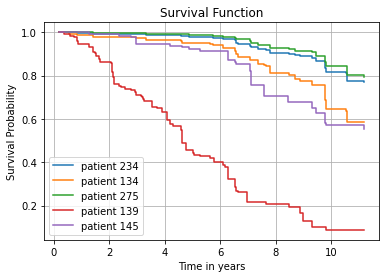

In [6]:
y = survCobra.predict_survival_function(X_test.iloc[0:5])

for i in range(len(y)):
    plt.step(eventTimes, y[i], where="post",label=f"patient {X_test.iloc[i].name}")

plt.xlabel("Time in years")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.title('Survival Function')
